# QOSF Mentorship Program Screening Task - Kunal Sinha

## TASK 4 - The chosen one

#### Find the lowest eigenvalue of the following matrix:

\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}

#### using VQE-like circuits, created by yourself from scratch.

### My understanding of the task: 

After learning about VQE from here [[1]], here [[2]], and here [[3]], following were the steps I decided to follow - 

1. Decomposition of the given Hamiltonian into the sum of tensor products of Pauli operators (Pauli terms).
2. Define an ansatz circuit.
3. Create a quantum circuit for each of the Pauli term and compute the expectation value of each of the term.
4. Try different wavefunctions (ansatz states) ∣ψ⟩ by varying the parameters of the ansatz circuit. The eigenvector ∣ψg⟩ that minimizes the expectation value ⟨H⟩ corresponds to the eigenvector of H that has the smallest eigenvalue.

[1]: https://nbviewer.jupyter.org/github/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb
[2]: https://www.mustythoughts.com/variational-quantum-eigensolver-explained
[3]: https://www.nature.com/articles/ncomms5213?origin=ppub

### The exact ground state energy for the given Hamiltonian:

In [1]:
import numpy as np
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.algorithms import NumPyEigensolver, VQE

In [2]:
pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": 0.5}, "label": "II"},
                   {"coeff": {"imag": 0.0, "real": -0.5}, "label": "XX"},
                   {"coeff": {"imag": 0.0, "real": -0.5}, "label": "YY"},
                   {"coeff": {"imag": 0.0, "real": 0.5}, "label": "ZZ"}
                   ]
    }
H = WeightedPauliOperator.from_dict(pauli_dict)

In [3]:
exact_result = NumPyEigensolver(H).run()
reference_energy = min(np.real(exact_result.eigenvalues))
print('The exact ground state energy is: {}'.format(reference_energy))

The exact ground state energy is: -1.0000000000000002


In [5]:
import pennylane as qml
from pennylane import numpy as np

### Step 1: Decomposition

The given two qubit Hamiltionian decomposes as follows:  
begin{equation} 
H=0.5 * II-0.5 * XX-0.5 * YY+0.5 * ZZ
end{equation}

The above equation is obtained from the following code - 

In [6]:
def HS(M1, M2):
    """Hilbert-Schmidt-Product of two matrices M1, M2"""
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def complex2string(c):
    """Return a string representation of a complex number c"""
    if c == 0.0:
        return "0"
    if c.imag == 0:
        return "%g" % c.real
    elif c.real == 0:
        return "%gj" % c.imag
    else:
        return "%g+%gj" % (c.real, c.imag)

def decompose(H):
    """Decompose Hermitian 4x4 matrix H into Pauli matrices"""
    from numpy import kron
    sx = np.array([[0, 1],  [ 1, 0]], dtype=np.complex128)
    sy = np.array([[0, -1j],[1j, 0]], dtype=np.complex128)
    sz = np.array([[1, 0],  [0, -1]], dtype=np.complex128)
    id = np.array([[1, 0],  [ 0, 1]], dtype=np.complex128)
    S = [id, sx, sy, sz]
    operators = ['I', 'sigma_x', 'sigma_y', 'sigma_z']
    for i in range(4):
        for j in range(4):
            operator = operators[i] + ' times ' + operators[j]
            a_ij = 0.25 * HS(kron(S[i], S[j]), H)
            if a_ij != 0.0:
                print("%s\t*\t( %s )" % (complex2string(a_ij), operator))

In [7]:
H = np.array(([[1, 0, 0, 0],[0, 0, -1, 0], [0, -1, 0, 0],[0, 0, 0, 1]]), dtype=np.complex128)
print(H)
decompose(H)

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]
0.5	*	( I times I )
-0.5	*	( sigma_x times sigma_x )
-0.5	*	( sigma_y times sigma_y )
0.5	*	( sigma_z times sigma_z )


### Step 2: The Ansatz

(I initially used the StronglyEntanglingLayers ansatz from Pennylane templates but later on tried the ansatz suggested in the tips)

In [8]:
def ansatz(x, **kwargs): 
    qml.Hadamard(wires=0) 
    qml.CNOT(wires=[0, 1])
    qml.RX(x[0], wires=0) 

### Step 3:  Creating the QNode (Quantum Circuit)

In [9]:
num_layers = 2
num_wires = 2

In [10]:
# Defining the Hamiltonian
coeffs = [0.5, -0.5, -0.5, 0.5]

obs = [
    qml.Identity(0) @ qml.Identity(1),
    qml.PauliX(0) @ qml.PauliX(1),
    qml.PauliY(0) @ qml.PauliY(1),
    qml.PauliZ(0) @ qml.PauliZ(1)
] # list of observables

In [11]:
# A device that estimates expectation values using a finite number of shots
dev = qml.device("default.qubit", wires=num_wires)

In [12]:
# QNode wraps the quantum function and binds it to the device.
# map() allows a single function of quantum operations (the ansatz in our case)  
# to be mapped across multiple observables(obs[]).

qnodes = qml.map(ansatz, obs, device=dev)

### Step 4: The cost function

In [13]:
total_shots = 8000

In [14]:
def cost(params):
    shots_per_term = [2000, 2000, 2000, 2000] 
    result = 0

    for h, c, s in zip(qnodes, coeffs, shots_per_term):
        # setting the number of shots
        h.device.shots = s

        # evaluating the QNode corresponding to
        # the Hamiltonian term, and adding it on to our running sum
        result += c * h(params)

    return result

In [15]:
init_params = [0.8]
print(cost(init_params))

0.6967067093471655


### Step 5: Optimization (Using Gradient Descent)

In [16]:
dev.shots = total_shots / len(coeffs)

cost = qml.dot(coeffs, qnodes) 

opt = qml.GradientDescentOptimizer(0.05)
params = init_params
# print(params)

cost_gdo = []
shots_gdo = []

for i in range(100):
    params = opt.step(cost, params)
    cost_gdo.append(cost(params))
    shots_gdo.append(total_shots*i)
    print("Step {}: cost = {} shots used = {}".format(i, cost_gdo[-1], shots_gdo[-1]))

Step 0: cost = 0.670534129531718 shots used = 0
Step 1: cost = 0.6425599797656292 shots used = 8000
Step 2: cost = 0.6127398125747127 shots used = 16000
Step 3: cost = 0.5810421461256896 shots used = 24000
Step 4: cost = 0.5474507557270925 shots used = 32000
Step 5: cost = 0.5119669351487525 shots used = 40000
Step 6: cost = 0.47461163817764057 shots used = 48000
Step 7: cost = 0.43542739822578225 shots used = 56000
Step 8: cost = 0.39447991503911595 shots used = 64000
Step 9: cost = 0.3518591943278058 shots used = 72000
Step 10: cost = 0.30768013004017397 shots used = 80000
Step 11: cost = 0.262082431279424 shots used = 88000
Step 12: cost = 0.2152298171608953 shots used = 96000
Step 13: cost = 0.16730843304026632 shots used = 104000
Step 14: cost = 0.1185244793222852 shots used = 112000
Step 15: cost = 0.06910108724625504 shots used = 120000
Step 16: cost = 0.019274521450737672 shots used = 128000
Step 17: cost = -0.03071016712054632 shots used = 136000
Step 18: cost = -0.08060387642

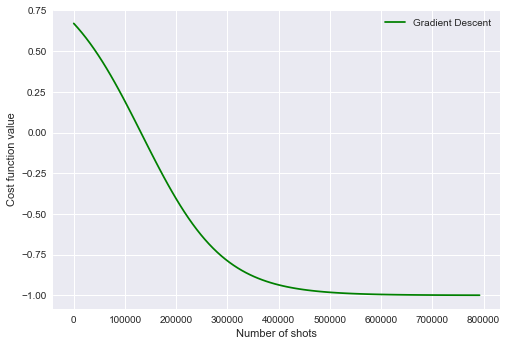

In [17]:
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(shots_gdo, cost_gdo, "g", label="Gradient Descent")

plt.ylabel("Cost function value")
plt.xlabel("Number of shots")
plt.legend()
plt.show()


### As we can see from the above plot the 'Cost function value' which in our case is the Eigen Value, approaches the exact value, i.e. -1

## With Pennylane 'StronglyEntanglingLayers' as the ansatz: 
StronglyEntanglingLayers - Layers consisting of single qubit rotations and entanglers, inspired by the circuit-centric classifier design https://arxiv.org/pdf/1804.00633.pdf.

In [18]:
from pennylane.templates.layers import StronglyEntanglingLayers
from pennylane.init import strong_ent_layers_uniform
init_params = strong_ent_layers_uniform(n_layers=num_layers, n_wires=num_wires)

In [19]:
dev.shots = total_shots / len(coeffs)

qnodes = qml.map(StronglyEntanglingLayers, obs, device=dev)
cost = qml.dot(coeffs, qnodes)

opt = qml.GradientDescentOptimizer(0.05)
params = init_params
# print(params)

cost_gdo = []
shots_gdo = []

for i in range(100):
    params = opt.step(cost, params)
    cost_gdo.append(cost(params))
    shots_gdo.append(total_shots*i)
    print("Step {}: cost = {} shots used = {}".format(i, cost_gdo[-1], shots_gdo[-1]))

Step 0: cost = 0.9293330110343727 shots used = 0
Step 1: cost = 0.910474064098698 shots used = 8000
Step 2: cost = 0.8868508506401009 shots used = 16000
Step 3: cost = 0.8574204620311121 shots used = 24000
Step 4: cost = 0.8210045713668757 shots used = 32000
Step 5: cost = 0.7763261357796948 shots used = 40000
Step 6: cost = 0.7220826184921886 shots used = 48000
Step 7: cost = 0.657066897075075 shots used = 56000
Step 8: cost = 0.5803422166267924 shots used = 64000
Step 9: cost = 0.49146546309925027 shots used = 72000
Step 10: cost = 0.39073228336155685 shots used = 80000
Step 11: cost = 0.27939109621394476 shots used = 88000
Step 12: cost = 0.15975107021786938 shots used = 96000
Step 13: cost = 0.03510865915696304 shots used = 104000
Step 14: cost = -0.09054641211913084 shots used = 112000
Step 15: cost = -0.21301322472092504 shots used = 120000
Step 16: cost = -0.32843887124476184 shots used = 128000
Step 17: cost = -0.4338030767684553 shots used = 136000
Step 18: cost = -0.527202306

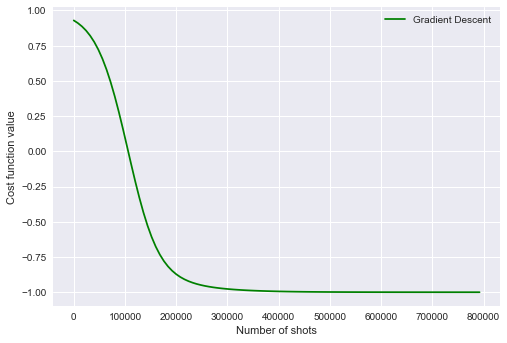

In [20]:
plt.style.use("seaborn")
plt.plot(shots_gdo, cost_gdo, "g", label="Gradient Descent")

plt.ylabel("Cost function value")
plt.xlabel("Number of shots")
plt.legend()
plt.show()

## References:
[1] : https://nbviewer.jupyter.org/github/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb 


[2] : https://www.mustythoughts.com/variational-quantum-eigensolver-explained


[3] : https://www.nature.com/articles/ncomms5213?origin=ppub

## Appendix

### Why did I use Pennylane?
I have recently started learning Pennylane and wanted to try out implementing VQE in it. 
Plus I first implemented everything in Qiskit following [[1]]. It pretty much seemed like copy-paste work (code wise). So yeah, doing the Pennylane implemention was more fun. 

[1]: https://nbviewer.jupyter.org/github/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb 

### Defining the circuit in Qiskit

In [21]:
def ansatz(circuit, parameters):
    q = circuit.qregs[0] # q is the quantum register where the info about qubits is stored
    circuit.h(q[0])
    circuit.cx(q[0], q[1])
    circuit.rx(parameters[0], q[0])
    circuit.id(q[1])
    return circuit

In [22]:
def vqe_circuit(parameters, measure):
    """
    Creates a device ansatz circuit for optimization.
    :param parameters_array: list of parameters for constructing ansatz state that should be optimized.
    :param measure: measurement type. 
    :return: quantum circuit.
    """
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # quantum state preparation
    circuit = ansatz(circuit, parameters)

    # measurement
    if measure == 'ZZ':
        circuit.measure([0,1], [0,1])
    elif measure == 'XX':
        circuit.h(q[0])
        circuit.h(q[1])
        circuit.measure([0,1], [0,1])
    elif measure == 'YY':
        circuit.y(q[0])
        circuit.y(q[1])
        circuit.measure([0,1], [0,1])
    else:
        raise ValueError('Not valid input for measurement: input should be "XX" or "YY" or "ZZ"')

    return circuit

## Thank you for the opportunity! :)